### Background

Our dataset contains transaction information on hundreds of thousands of recorded opioid sales in the United States from 2006-2012. Our data comes from the DEA's ARCOS Dataset, which kept record of all opioid transactions to pharmacies in every state for these 6 years. Our dataset does not contain any data on individual buyers, but rather contains data about where the transaction occured, when, what was sold, and how much was sold to each retailer. Combining this data from Arcos with Census data for Ohio counties, such as average age and average income, can give us an idea of what company targeted what area, or what demographic. We can use the data we have available to us to find key characteristics that pharmaceutical companies look for when deciding who to target for opioid sales. Since the opioid epidemic is such a widespread issue throughout the United States even today, this is information the public needs to see and understand. Anyone effected by the opioid epidemic should investigate the full extent of the dangerous overprescription by these companies in both Ohio cities and the United States as a whole. 

### Data

Our data gives us access to multiple columns of information on hundreds of thousands of opioid transactions to pharmacies around the United States. To find out what companies sold to how many people and where, we will have to thoroughly explore our data around different times and in different states and counties within states. Combining our transaction data with United States Census data about individual states and counties allows us to further explore what places the opioid crisis has affected the most. By combining data from these two datasets, for example, we can find what Ohio counties the most opioid transactions have occured in, how many opioids there are in the county compared to how many people live there, and how many sales there were in different counties of varying economic status. We can also get a general idea of what type of person pharmaceutical companies typically target opioid sales to, as we have access to average county age and average income per person in each county.

In [0]:
#@title 
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#@title 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls 'drive/My Drive/arcos-oh-statewide-itemized.tsv.gz'
!ls 'drive/My Drive/co-est00int-01-39.xls'

Mounted at /content/drive
'drive/My Drive/arcos-oh-statewide-itemized.tsv.gz'
'drive/My Drive/co-est00int-01-39.xls'


In [0]:
#@title 
test= pd.read_csv('drive/My Drive/arcos-oh-statewide-itemized.tsv.gz', sep='\t', error_bad_lines = False)
# Drop Unnecessary Columns
simpleOhio = test[['BUYER_NAME','BUYER_ADDRESS1', 'BUYER_ADDRESS2', 'BUYER_CITY', 'BUYER_STATE', 'BUYER_ZIP', 'BUYER_COUNTY','DRUG_NAME', 'QUANTITY', 'UNIT', 'TRANSACTION_DATE', 'CALC_BASE_WT_IN_GM', 'DOSAGE_UNIT', 'Product_Name', 'Ingredient_Name','Revised_Company_Name', 'Reporter_family']]
simpleOhio.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,5,22,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.



,BUYER_NAME,BUYER_ADDRESS1,BUYER_ADDRESS2,BUYER_CITY,BUYER_STATE,BUYER_ZIP,BUYER_COUNTY,DRUG_NAME,QUANTITY,UNIT,TRANSACTION_DATE,CALC_BASE_WT_IN_GM,DOSAGE_UNIT,Product_Name,Ingredient_Name,Revised_Company_Name,Reporter_family
0,"BACH, JOHN M DVM",WAVERLY VETERINARY HOSPITAL INC,95 WOODLAND DRIVE,WAVERLY,OH,45690,PIKE,HYDROCODONE,1.0,NaN,7252007,0.3027,100.0,HYDROCOD.BIT. 5MG/HOMATROPINE.METHYL,HYDROCODONE BITARTRATE HEMIPENTAHYDRATE,"Allergan, Inc.",Columbus Serum Co
1,"COUNTS, GAIL E DVM",SHAWNEE ANIMAL CLINIC,101 BIERLY RD,PORTSMOUTH,OH,45662,SCIOTO,HYDROCODONE,1.0,NaN,7102006,0.3027,100.0,HYDROCOD.BIT. 5MG/HOMATROPINE.METHYL,HYDROCODONE BITARTRATE HEMIPENTAHYDRATE,"Allergan, Inc.",Columbus Serum Co
2,"COUNTS, GAIL E DVM",SHAWNEE ANIMAL CLINIC,101 BIERLY RD,PORTSMOUTH,OH,45662,SCIOTO,HYDROCODONE,2.0,NaN,11102009,0.6054,200.0,TUSSIGON 5MG HYD.BIT&HOMA MBR 1.5MG/,HYDROCODONE BITARTRATE HEMIPENTAHYDRATE,Pfizer Laboratories Div Pfizer Inc,Columbus Serum Co
3,"DRESBACH, HUGH DELNO DVM",1130 NORTH COURT STREET,NaN,CIRCLEVILLE,OH,43113,PICKAWAY,HYDROCODONE,5.0,NaN,7112007,1.5135,500.0,HYDROCOD.BIT. 5MG/HOMATROPINE.METHYL,HYDROCODONE BITARTRATE HEMIPENTAHYDRATE,"Allergan, Inc.",Columbus Serum Co
4,"FARST, DAVID W DVM",510 N MAIN STREET,NaN,ARCANUM,OH,45304,DARKE,HYDROCODONE,1.0,NaN,11282006,0.3027,100.0,HYDROCOD.BIT. 5MG/HOMATROPINE.METHYL,HYDROCODONE BITARTRATE HEMIPENTAHYDRATE,"Allergan, Inc.",Columbus Serum Co


In [0]:
#@title 
#census data from US Census Website
censusData = pd.ExcelFile('drive/My Drive/co-est00int-01-39.xls')
censusData.sheet_names
df = censusData.parse('CO-EST00INT-01-39')
df.columns = df.loc[0]
df = df.drop(df.index[0])
df.reset_index(drop = True, inplace= True)
#Get average county population for timeframe of ARCOS
df.columns = ['County','gone','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']
census = df.drop(['gone','2000','2001','2002','2003','2004','2005','2010','2011'], axis=1)
censusOhio = census.drop(census.index[0])
censusOhio.reset_index(drop = True, inplace = True)
countyPop = censusOhio.loc[:, "2006":"2009"]
censusOhio['countyPop'] = countyPop.mean(axis=1)
censusOhio = censusOhio.dropna()
censusOhio['countyPop'] = censusOhio['countyPop'].astype(int)
censusOhio.head()

,County,2006,2007,2008,2009,countyPop
0,.Adams County,28615.0,28538.0,28686.0,28500.0,28584
1,.Allen County,106716.0,106717.0,106773.0,106518.0,106681
2,.Ashland County,53231.0,53544.0,53499.0,53305.0,53394
3,.Ashtabula County,102340.0,102156.0,101826.0,101584.0,101976
4,.Athens County,64237.0,64102.0,64546.0,64618.0,64375


### Methodology

Using the data we have available from these datasets, we can explore such questions as which counties have been sold the most opioids, which drugs have been sold the most, and what companies are most responsible for these transactions. 

Below is a basic visualization of the top 5 pharmaceutical companies with the most transactions within all 7 included years of the ARCOS dataset. We can use this data to get a better idea of what companies have gained the most from overprescribing opioids in the state of Ohio. From here, we can explore what counties these companies have sold to the most, and what medication these companies are selling in these transactions. We will also be able to tell the top overprescribing companies in each county, and if these companies typically target old or young counties, or perhaps high income or low income counties.

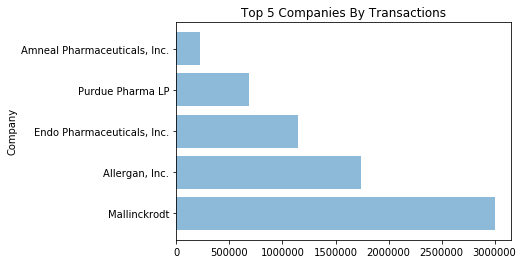

In [0]:
#@title 
countByCompany = simpleOhio.groupby('Revised_Company_Name').size().reset_index(name = 'counts')
companiesSorted = countByCompany.sort_values(by = ['counts'], ascending= False)
top5 = companiesSorted[:5]
objects = top5.Revised_Company_Name
y_pos = np.arange(len(objects))
values = top5.counts
plt.barh(y_pos, values, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Company')
plt.title('Top 5 Companies By Transactions')

plt.show()

We can also use the data available to us to compare each county in a state to see what areas have been affected most over time. We are able to see how transactions per county have changed from year to year. We can also use locational data from ARCOS to see what medications have been sold the most by county and what counties have the most transactions per the population of the county. 

Below is a simple heatmap generated using plotly that shows how many transactions have occured in each county for every year combined in the ARCOS dataset. This heatmap can be replicated for each year to show the change in amount of transactions per county over time.

In [0]:
#@title 
# Fips code for each county -- used in plotly
FIPS = ['39001','39003', '39005', '39007', '39009', '39011', '39013', '39015','39017', '39019', '39021', '39023', '39025', '39027', '39029', '39031', '39033', '39035', '39037', '39039', '39041', \
        '39043', '39045', '39047', '39049', '39051', '39053', '39055', '39057', '39059', '39061', '39063', '39065', '39067', '39069', '39071', '39073', '39075', '39077', '39079', '39081',\
        '39083', '39085', '39087', '39089', '39091', '39093', '39095', '39097', '39099', '39101', '39103', '39105', '39107', '39109', '39111', '39113', '39115', '39117', '39119', '39121',\
        '39123', '39125', '39127', '39129', '39131', '39133', '39135', '39137', '39139', '39141', '39143', '39145', '39147', '39149', '39151', '39153', '39155', '39157', '39159', '39161', \
        '39163', '39165', '39167', '39169', '39171', '39173', '39175']


#plotly heat map -- transactions by county
import plotly.figure_factory as ff
!pip install plotly-geo
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install plotly==4.1.0

countByCounty = simpleOhio.groupby('BUYER_COUNTY').size().reset_index(name = 'counts')
countByCounty

values = countByCounty['counts'].tolist()
fig = ff.create_choropleth(fips=FIPS, values=values, scope = ['OH'], legend_title = 'Number of Transactions', title = 'Total Opioid Transactions in Ohio', county_outline={'color': 'rgb(255,255,255)', 'width': 0.5})
fig.layout.template = None

fig.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




We can also use the data we have from ARCOS to find out what type of prescription medication has been sold to what pharmacy, how much of it has been sold, and we can find out the total magnitude of how much medication has been sold by exploring how much total weight of what medication has been sold. Exploring types of prescriptions can provide more insight as to what medications have been most targeted to what county and perhaps we can also tell if a medication is more likely to be sold in a poor or wealthy county, or a more or less populated county.

Below is another basic visualization created using the library Matplotlib showing the distribution of total transactions including each drug type in Ohio over all years the ARCOS database covers. This can be taken further by showing the total weight of each drug sold in each county. We can get a better understanding of just how many opioids have been purchased in each county by calculating how much of each medication is included in all transactions in a State or county, both by number of transactions and by total weight.

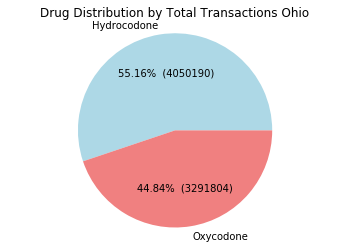

In [0]:
#@title 
drugDist = simpleOhio.groupby('DRUG_NAME')
hydro = drugDist.count()['BUYER_NAME'][0]
oxy = drugDist.count()['BUYER_NAME'][1]

#Charts for total drug distribution Ohio
labels = 'Hydrocodone','Oxycodone'
sizes = hydro, oxy
colors = ['lightblue', 'lightcoral']



def make_autopct(sizes):
    def my_autopct(pct):
        total = sum(sizes)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#Plot
plt.pie(sizes, labels = labels, colors = colors, autopct=make_autopct(values))
plt.axis('equal')
plt.title("Drug Distribution by Total Transactions Ohio")
plt.show()

From here, we can use machine learning to further explore the data. By clustering the data by county and combining the data from the United States Census site with the data from ARCOS, we can see where counties fall when comparing average age or average income of a county by total transactions in each county. We can cluster this county information to create groups based on transaction information. We can find what age groups have been targeted most by pharmaceutical companies and what drug is most likely to be sold to a county of what average income.

We can also use machine learning to make predictions on whether a county is likely to have a high amount of opioid transactions based on transactiton and population data we have access to. We can make predictions based on a variety of quantitative values we have available to us from this set. Perhaps by using machine learning we can also tell what county is likely to sell a certain type of drug to a certain demographic. The datasets we are exploring and analyzing can give a much clearer picture of how severe the impact of the opioid epidemic has been, and where it has had the greatest effect on the country.